# Automated ML


In [1]:
# Updating SDK as suggested by mentor
# I ran the line and then deleted the cell´s output to declutter the notebook
!pip install --upgrade --upgrade-strategy eager azureml-sdk[automl,widgets,notebooks]

Requirement already up-to-date: azureml-sdk[automl,notebooks,widgets] in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.21.0)
Requirement already up-to-date: azureml-core~=1.21.0 in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (from azureml-sdk[automl,notebooks,widgets]) (1.21.0.post1)
Requirement already up-to-date: azureml-dataset-runtime[fuse]~=1.21.0 in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (from azureml-sdk[automl,notebooks,widgets]) (1.21.0)
Requirement already up-to-date: azureml-train-automl-client~=1.21.0 in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (from azureml-sdk[automl,notebooks,widgets]) (1.21.0)
Requirement already up-to-date: azureml-train~=1.21.0 in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (from azureml-sdk[automl,notebooks,widgets]) (1.21.0)
Requirement already up-to-date: azureml-pipeline~=1.21.0 in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (from azureml-sdk[automl,notebooks,widgets]

In [2]:
from azureml.core import Workspace, Experiment, Dataset, Datastore, Model
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.widgets import RunDetails
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.train.automl import AutoMLConfig
from azureml.interpret import ExplanationClient
from interpret_community.widget import ExplanationDashboard
from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice
import pandas as pd
import numpy as np
import joblib
import pickle
import json
import requests

In [3]:
ws = Workspace.from_config()
experiment_name = 'california-housing'
experiment2=Experiment(ws, experiment_name)

## Create or use a compute target

In [4]:
compute_name = "nuria-p3"
try:
    compute_target = ComputeTarget(workspace=ws, name=compute_name)
    print('Using existing compute target.')
except ComputeTargetException:
    print('Creating compute target.')
    cluster_type = 1
    provisioning_config = AmlCompute.provisioning_configuration(vm_size='Standard_D12_V2', min_nodes=1, max_nodes=5)
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

compute_target.wait_for_completion(show_output=True)

Using existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [5]:
# load data and create datasets for training and testing
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

def create_datasets(x,y):
    columns_x = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']
    x_df = pd.DataFrame(x,columns=columns_x)  
    columns_y = ['MedHouseVal']
    y_df = pd.DataFrame(y,columns=columns_y)  
    x_tr,x_test,y_tr,y_test = train_test_split(x_df,y_df, test_size = 20, random_state=0)
    return x_tr,x_test,y_tr,y_test
  
x,y = fetch_california_housing(return_X_y=True)
x_train,x_test,y_train,y_test = create_datasets(x,y)
data = pd.concat([x_train,y_train], axis=1)

In [6]:
# Check if train dataset is already registered, if not, register it.
found = False
datastore=ws.get_default_datastore() 
if 'data' in ws.datasets.keys(): 
        found = True
if not found:
        TabularDatasetFactory.register_pandas_dataframe(data, datastore,'data')
ds = Dataset.get_by_name(ws,'data')

### NOTE: the method used above is experimental, if it does break in the future, use this procedure (create data directory if needed)
                     
`` data.to_csv('data/data_csv.csv')``                  
`` datastore.upload(src_dir='data', target_path='data')``                                                   
`` ds = Dataset.Tabular.from_delimited_files(path = [(datastore, ('data/data_csv.csv'))])`` 

## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [7]:
# TODO: Put your automl settings here
automl_settings = { "experiment_timeout_minutes": 60,
                    "max_concurrent_iterations": 5,
                    "primary_metric" : 'r2_score'}      

# TODO: Put your automl config here
automl_config = AutoMLConfig(compute_target=compute_target,
                             task = 'regression',
                             training_data = ds,
                             label_column_name ='MedHouseVal',
                             featurization = 'auto',
                             enable_early_stopping = True,
                             model_explainability = True,
                             validation_size = 0.2,
                             path = './automl',
                             debug_log = 'automl_errors.log',
                             **automl_settings)

In [8]:
# TODO: Submit your experiment
remote_run = experiment2.submit(automl_config)

Running on remote.


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [9]:
RunDetails(remote_run).show()
remote_run.wait_for_completion(show_output=True)

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

*********************************

{'runId': 'AutoML_d27e685c-6ed4-4f11-ac21-ee153a1dfbaf',
 'target': 'nuria-p3',
 'status': 'Completed',
 'startTimeUtc': '2021-01-26T19:11:20.127906Z',
 'endTimeUtc': '2021-01-26T19:37:04.288211Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'r2_score',
  'train_split': '0.2',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'nuria-p3',
  'AMLSettingsJsonString': '{"path":null,"name":"california-housing","subscription_id":"9a7511b8-150f-4a58-8528-3e7d50216c31","resource_group":"aml-quickstarts-136165","workspace_name":"quick-starts-ws-136165","region":"southcentralus","compute_target":"nuria-p3","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"r2_score","task_type":"regression","data_script":null,"validation_size":0.2,"n_cross_validations":null,"y_min":null,"y_max":null,"num_classes":null,"fea

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



### Inspect Some Results From Experiment

In [10]:
# Summary of models attempted by AUTOML
remote_run.summary()

[['VotingEnsemble', 1, 0.8553625693695082],
 ['StackEnsemble', 1, 0.855029393382505],
 ['XGBoostRegressor', 12, 0.84854969316053],
 ['Failed', 2, nan],
 ['ExtremeRandomTrees', 7, 0.7152837474850906],
 ['RandomForest', 9, 0.7715692888611618],
 ['LightGBM', 2, 0.841866504256535],
 ['ElasticNet', 5, 0.6082912953839973],
 ['LassoLars', 1, 0.6084125424314998]]

In [13]:
# Get all metrics for all iteartions  (I will print only 5, to save space)

N = 39             # change for number of iterations in the experiment
list_metrics = []
for i in range(N):
    try:
        r, m = remote_run.get_output(iteration = i + 1)
        temp = r.get_metrics()
        temp.pop('residuals', 'No Key found') 
        temp.pop('predicted_true', 'No Key found') 
        temp['Run ID'] = r.id
        list_metrics.append(temp)
    except:    
        pass                              ## this skips failed iterations
out = pd.DataFrame(list_metrics)
print(out.head())

   median_absolute_error  spearman_correlation  \
0                   0.25                  0.89   
1                   0.37                  0.79   
2                   0.31                  0.87   
3                   0.19                  0.92   
4                   0.45                  0.76   

   normalized_root_mean_squared_log_error  normalized_median_absolute_error  \
0                                    0.10                              0.05   
1                                    0.13                              0.08   
2                                    0.11                              0.06   
3                                    0.08                              0.04   
4                                    0.14                              0.09   

   root_mean_squared_error  r2_score  explained_variance  \
0                     0.52      0.79                0.79   
1                     0.66      0.66                0.66   
2                     0.58      0.74        

### Retieve Best Model

In [14]:
# Get best model metrics
best_metrics = remote_run.get_metrics()
print(best_metrics)

{'experiment_status': ['DatasetEvaluation', 'FeaturesGeneration', 'DatasetFeaturization', 'DatasetFeaturizationCompleted', 'ModelSelection'], 'experiment_status_description': ['Gathering dataset statistics.', 'Generating features for the dataset.', 'Beginning to fit featurizers and featurize the dataset.', 'Completed fit featurizers and featurizing the dataset.', 'Beginning model selection.'], 'root_mean_squared_log_error': 0.13101593608885115, 'normalized_root_mean_squared_error': 0.08910928282024148, 'root_mean_squared_error': 0.4321818038638276, 'normalized_mean_absolute_error': 0.058592725786155174, 'median_absolute_error': 0.18240552254176157, 'r2_score': 0.8553625693695082, 'mean_absolute_error': 0.2841758919173683, 'normalized_root_mean_squared_log_error': 0.07930708863118689, 'mean_absolute_percentage_error': 16.05211560820331, 'normalized_median_absolute_error': 0.03760923100147248, 'explained_variance': 0.8553811876248657, 'spearman_correlation': 0.9290035362293845}


In [15]:
# Retrive best model
best_run, fitted_model = remote_run.get_output()

In [16]:
# RunID of the best model
print(best_run)

Run(Experiment: california-housing,
Id: AutoML_d27e685c-6ed4-4f11-ac21-ee153a1dfbaf_38,
Type: azureml.scriptrun,
Status: Completed)


In [17]:
# Best Model
print(fitted_model)

RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                             logger=None,
                                                             observer=None,
                                         

In [18]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('4',
                                            Pipeline(memory=None,
                                                     steps=[('standardscalerwrapper',
                                                             <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f813986ce10>),
                                                            ('xgboostregressor',
                                                             XGBoostRegressor(base_score=0.5,
                                                                              booster='gbtree',
                                                                              colsample_bylevel=1,
                                                                              colsample_bynode=1,
                                                                              colsample_bytree=0.9,
                                                                              eta=0.5,
                                                                              gamma=0,
                                                                              importance_typ...
                                                                               learning_rate=0.1,
                                                                               max_depth=-1,
                                                                               min_child_samples=20,
                                                                               min_child_weight=0.001,
                                                                               min_split_gain=0.0,
                                                                               n_estimators=100,
                                                                               n_jobs=1,
                                                                               num_leaves=31,
                                                                               objective=None,
                                                                               random_state=None,
                                                                               reg_alpha=0.0,
                                                                               reg_lambda=0.0,
                                                                               silent=True,
                                                                               subsample=1.0,
                                                                               subsample_for_bin=200000,
                                                                               subsample_freq=0,
                                                                               verbose=-1))],
                                                     verbose=False))],
                               weights=[0.4, 0.4, 0.06666666666666667,
                                        0.13333333333333333]))]

In [19]:
# Helper function to get model.steps information
# source: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-features#featurization-transparency
from pprint import pprint

def print_model(model, prefix=""):
    for step in model.steps:
        print(prefix + step[0])
        if hasattr(step[1], 'estimators') and hasattr(step[1], 'weights'):
            pprint({'estimators': list(
                e[0] for e in step[1].estimators), 'weights': step[1].weights})
            print()
            for estimator in step[1].estimators:
                print_model(estimator[1], estimator[0] + ' - ')
        else:
            pprint(step[1].get_params())
            print()

print_model(fitted_model)

datatransformer
{'enable_dnn': None,
 'enable_feature_sweeping': None,
 'feature_sweeping_config': None,
 'feature_sweeping_timeout': None,
 'featurization_config': None,
 'force_text_dnn': None,
 'is_cross_validation': None,
 'is_onnx_compatible': None,
 'logger': None,
 'observer': None,
 'task': None,
 'working_dir': None}

prefittedsoftvotingregressor
{'estimators': [('4',
                 Pipeline(memory=None,
         steps=[('standardscalerwrapper',
                 <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f813986ce10>),
                ('xgboostregressor',
                 XGBoostRegressor(base_score=0.5, booster='gbtree',
                                  colsample_bylevel=1, colsample_bynode=1,
                                  colsample_bytree=0.9, eta=0.5, gamma=0,
                                  importance_type='gain', learning_rate=0.1,
                                  max_delta_step=0, max_depth=6, max_leaves=15,
               

In [20]:
fitted_model.named_steps['datatransformer'].get_featurization_summary()

[{'RawFeatureName': 'MedInc',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'HouseAge',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'AveRooms',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'AveBedrms',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'Population',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'AveOccup',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'Latitude',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'Longitude',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']}]

### Save and Register Best Model

In [21]:
#TODO: Save the best model
joblib.dump(fitted_model, filename='automl/best-automl.joblib')

['automl/best-automl.joblib']

In [22]:
# register model
model = remote_run.register_model(model_name='best-automl')

In [23]:
# look at the model
print(model.name,model.id,model.version,sep='\t')

best-automl	best-automl:1	1


In [28]:
# download the model
model.download(target_dir='automl/model.pkl', exist_ok=False, exists_ok=None)

'automl/model.pkl/model.pkl'

### Try Best Model on the Test Dataset

In [29]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

     |████████████████████████████████| 285 kB 7.4 MB/s eta 0:00:01


In [30]:
from sklearn.metrics import r2_score
try:
    y_pred = fitted_model.predict(x_test)
    residuals = y_test['MedHouseVal'] - y_pred
    r2 = r2_score(y_test, y_pred)
    print('R2 score for test data: ',r2)
except Exception as e:
    print(str(e))

R2 score for test data:  0.9258023730000582


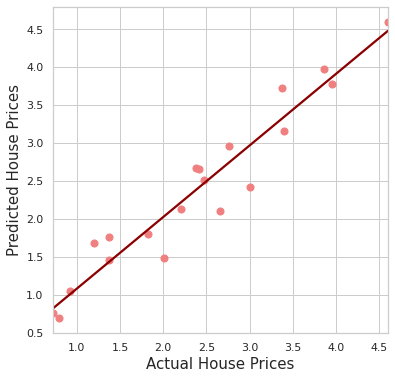

In [31]:
# Plot actual vs. fitted values for the test dataset
plt.figure(figsize=(6, 6))
sns.regplot(x=y_test['MedHouseVal'], y=y_pred, x_estimator=np.mean, ci=None, scatter=False, color='darkred')
sns.regplot(x=y_test['MedHouseVal'], y=y_pred, x_estimator=np.mean, ci=None, fit_reg=False, color='lightcoral')
plt.xlabel('Actual House Prices',fontsize = 15)
plt.ylabel('Predicted House Prices',fontsize = 15)
plt.show()

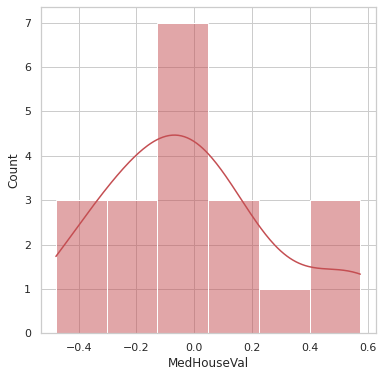

In [32]:
# Distribution of the residuals
plt.figure(figsize=(6, 6))
ax = sns.histplot(data=residuals, kde=True, color='r')
plt.show()

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [37]:
# Retrive the registered model
model = Model(ws, 'best-automl')

In [38]:
# Environment
try:
    best_run.download_file('outputs/conda_env_v_1_0_0.yml', 'automl/auto_conda_env.yml')  ## si no funciona reemplazar automl por .
    env = Environment.from_conda_specification('myenv','automl/auto_conda_env.yml')
except Exception as e:
    print(str(e))

In [39]:
# Scoring file
try:
    best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'automl/score.py')  
except Exception as e:
    print(str(e)) 

In [40]:
# inference config
inference_config = InferenceConfig(entry_script='automl/score.py', environment=env)

# deployment config
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1, auth_enabled=True, enable_app_insights=True)

In [41]:
# deploy
try:
    service = Model.deploy(ws, "california-housing", [model], inference_config, deployment_config, overwrite=True)
    service.wait_for_deployment(show_output = True)
    print(service.state)
except Exception as e:
    print(str(e))

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...................................................................................................................................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


TODO: In the cell below, send a request to the web service you deployed to test it.

### Get service information

In [42]:
scoring_uri = service.scoring_uri
print('URI: ', scoring_uri)

URI:  http://1c1011ea-7331-478e-ac54-899cde415661.southcentralus.azurecontainer.io/score


In [43]:
keys = service.get_keys()
print('KEYS: ', keys)

KEYS:  ('cATsFJA9hhUPQisOzCyZAsIp1BiEBPYy', 'H2HeJXG276uqj8JYUfUgEOZkRLQo5cVU')


In [44]:
swag = service.swagger_uri
print(swag)

http://1c1011ea-7331-478e-ac54-899cde415661.southcentralus.azurecontainer.io/swagger.json


In [45]:
serv = service.serialize()
#print(serv)

### try the service

In [46]:
test = x_test[0:10]
input_payload = json.dumps({'data': test.to_numpy().tolist()})
output = service.run(input_payload)
print(output)

{"result": [1.4618726543302587, 2.6647999671275993, 1.4843392111378706, 0.7611031035869795, 4.598881336878318, 1.6788095733029562, 2.512055535799478, 3.724994229352508, 3.1593949606066145, 2.098471795122479]}


### send request to the endpoint

In [47]:
# prepare data
x_test_json = test[0:10].to_json(orient='records') 
data = "{\"data\": " + x_test_json +"}"

In [48]:
headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ keys[0])}

In [49]:
# send request
resp = requests.post(scoring_uri, data, headers=headers)
print(resp)

<Response [200]>


In [50]:
y_pred = json.loads(json.loads(resp.text))['result']
print('result:', y_pred)

result: [1.4618726543302587, 2.6647999671275993, 1.4843392111378706, 0.7611031035869795, 4.598881336878318, 1.6788095733029562, 2.512055535799478, 3.724994229352508, 3.1593949606066145, 2.098471795122479]


TODO: In the cell below, print the logs of the web service and delete the service

In [51]:
print(service.get_logs())

2021-01-26T20:15:11,344479271+00:00 - gunicorn/run 
2021-01-26T20:15:11,345360572+00:00 - rsyslog/run 
2021-01-26T20:15:11,345679372+00:00 - iot-server/run 
2021-01-26T20:15:11,353103378+00:00 - nginx/run 
rsyslogd: /azureml-envs/azureml_4f26b5b9300bb3a3b89415c34dafac63/lib/libuuid.so.1: no version information available (required by rsyslogd)
/usr/sbin/nginx: /azureml-envs/azureml_4f26b5b9300bb3a3b89415c34dafac63/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_4f26b5b9300bb3a3b89415c34dafac63/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_4f26b5b9300bb3a3b89415c34dafac63/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_4f26b5b9300bb3a3b89415c34dafac63/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml

## UNCOMMENT AND RUN THIS AT THE END, AFTER HAVING DOCUMENTED AND SAVED EVERYTHING

In [54]:
# Delete web service
service.delete()

In [55]:
# Delete cluster
compute_target.delete()